<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Loading-Data" data-toc-modified-id="Loading-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Loading Data</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Holyday-Variables" data-toc-modified-id="Holyday-Variables-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Holyday Variables</a></span></li><li><span><a href="#Training-and-Out-of-Time-Data" data-toc-modified-id="Training-and-Out-of-Time-Data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Training and Out of Time Data</a></span></li></ul></li><li><span><a href="#EDA" data-toc-modified-id="EDA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Montly-analysis" data-toc-modified-id="Montly-analysis-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Montly analysis</a></span></li><li><span><a href="#daily-analysis" data-toc-modified-id="daily-analysis-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>daily analysis</a></span></li><li><span><a href="#Hourly-analisys" data-toc-modified-id="Hourly-analisys-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Hourly analisys</a></span></li><li><span><a href="#General" data-toc-modified-id="General-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>General</a></span></li></ul></li><li><span><a href="#Naive-predictor" data-toc-modified-id="Naive-predictor-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Naive predictor</a></span></li><li><span><a href="#SARIMAX" data-toc-modified-id="SARIMAX-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>SARIMAX</a></span></li><li><span><a href="#FB-Prophet" data-toc-modified-id="FB-Prophet-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>FB Prophet</a></span></li><li><span><a href="#Modeling-One-Hot-Encoding" data-toc-modified-id="Modeling-One-Hot-Encoding-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Modeling One Hot Encoding</a></span><ul class="toc-item"><li><span><a href="#Random-Forests" data-toc-modified-id="Random-Forests-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Random Forests</a></span><ul class="toc-item"><li><span><a href="#Random-Search" data-toc-modified-id="Random-Search-8.1.1"><span class="toc-item-num">8.1.1&nbsp;&nbsp;</span>Random Search</a></span></li><li><span><a href="#Grid-Search" data-toc-modified-id="Grid-Search-8.1.2"><span class="toc-item-num">8.1.2&nbsp;&nbsp;</span>Grid Search</a></span></li></ul></li><li><span><a href="#lightGBM" data-toc-modified-id="lightGBM-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>lightGBM</a></span><ul class="toc-item"><li><span><a href="#Random-Search" data-toc-modified-id="Random-Search-8.2.1"><span class="toc-item-num">8.2.1&nbsp;&nbsp;</span>Random Search</a></span></li><li><span><a href="#Grid-Search" data-toc-modified-id="Grid-Search-8.2.2"><span class="toc-item-num">8.2.2&nbsp;&nbsp;</span>Grid Search</a></span></li></ul></li></ul></li><li><span><a href="#Modeling-Label-Encoding" data-toc-modified-id="Modeling-Label-Encoding-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Modeling Label Encoding</a></span></li><li><span><a href="#Importance-of-Variables" data-toc-modified-id="Importance-of-Variables-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Importance of Variables</a></span></li></ul></div>

# Imports

In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from functools import reduce

from fbprophet import Prophet

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import spearmanr, pearsonr
from datetime import datetime, timedelta
from sklearn.model_selection import TimeSeriesSplit,RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn import preprocessing

from getdata import getdata
from utils import *

pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)

download_data = False
training = True
seed=42



# Downloading data from ANAC site
if download_data:
    getdata(period = ('2016-01','2020-05')) # sumarizes all the months in a single file and do initial dataprep / creates the data.csv file


# Loading Data

In [141]:
# Loading Data
anac_df = pd.read_csv("ANAC_DATA/data.csv", low_memory=False)


# Getting brazilian holidays
feriados = pd.read_csv("feriados.csv")

In [142]:
# checking data shape
anac_df.shape, feriados.shape

((3610445, 20), (57, 3))

In [143]:
# sample
anac_df.head()

,id_basica,sg_empresa_icao,ds_tipo_empresa,ds_grupo_di,ds_servico_tipo_linha,nr_ano_partida_real,hr_partida_real,dt_partida_real,nm_mes_partida_real,nr_mes_partida_real,nm_dia_semana_partida_real,nr_dia_partida_real,sg_iata_origem,sg_uf_origem,nm_municipio_origem,sg_iata_destino,nr_assentos_ofertados,nr_passag_pagos,km_distancia,nr_horas_voadas
0,12017073,AZU,TRANSPORTE AÉREO REGULAR,NÃO REGULAR,PASSAGEIRO,2016.0,13:26:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,SSA,BA,SALVADOR,MCZ,69,0,468.0,"1,37"
1,12017127,AZU,TRANSPORTE AÉREO REGULAR,NÃO REGULAR,PASSAGEIRO,2016.0,10:26:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,BPS,BA,PORTO SEGURO,VCP,118,98,1115.0,"1,77"
2,12017128,AZU,TRANSPORTE AÉREO REGULAR,NÃO REGULAR,PASSAGEIRO,2016.0,23:30:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,CNF,MG,CONFINS,NAT,118,106,1800.0,"2,68"
3,12017129,AZU,TRANSPORTE AÉREO REGULAR,NÃO REGULAR,PASSAGEIRO,2016.0,03:09:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,MCZ,AL,RIO LARGO,CNF,118,49,1427.0,"2,23"
4,12017130,AZU,TRANSPORTE AÉREO REGULAR,NÃO REGULAR,PASSAGEIRO,2016.0,13:18:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,IGU,PR,FOZ DO IGUAÇU,CWB,70,64,533.0,"1,43"


In [144]:
# sample
feriados.head()

,data,fl_feriado,desc_feriado
0,2016-01-01,1,confraternização universal (feriado nacional)
1,2016-02-09,1,(terça-feira ) – Carnaval (ponto facultativo)
2,2016-02-10,1,(quarta-feira ) – Quarta-feira Cinzas (ponto...
3,2016-03-25,1,(sexta-feira ) – Paixão Cristo (feriado naci...
4,2016-04-21,1,(quinta-feira) – Tirantes (feriado nacional)


In [145]:
# filter route SP-RJ

df_sp = anac_df.query("(sg_iata_origem == 'CGH')|(sg_iata_origem == 'GRU') & (sg_iata_destino == 'GIG'| sg_iata_destino == 'SDU') & nr_passag_pagos !=0")

# Feature Engineering

## Holyday Variables

In [146]:
# creating variables for 1,2 and 3 days before a holiday

feriados['data_d1'] = feriados.data.apply(lambda x: str((datetime.strptime(x, '%Y-%m-%d')- timedelta(days=1)).date()))
feriados['data_d2'] = feriados.data.apply(lambda x: str((datetime.strptime(x, '%Y-%m-%d')- timedelta(days=2)).date()))
feriados['data_d3'] = feriados.data.apply(lambda x: str((datetime.strptime(x, '%Y-%m-%d')- timedelta(days=3)).date()))

feriados['fl_feriado_d1'] = feriados.fl_feriado
feriados['fl_feriado_d2'] = feriados.fl_feriado
feriados['fl_feriado_d3'] = feriados.fl_feriado

In [147]:
# joins with df_sp
df_sp = df_sp.merge(feriados[['data','fl_feriado']], left_on='dt_partida_real', right_on='data', how = 'left')
df_sp = df_sp.merge(feriados[['data_d1','fl_feriado_d1']], left_on='dt_partida_real', right_on='data_d1', how = 'left')
df_sp = df_sp.merge(feriados[['data_d2','fl_feriado_d2']], left_on='dt_partida_real', right_on='data_d2', how = 'left')
df_sp = df_sp.merge(feriados[['data_d3','fl_feriado_d3']], left_on='dt_partida_real', right_on='data_d3', how = 'left')

In [148]:
# filling nulls
df_sp.fillna(0,inplace=True)

In [149]:
# droping variables

keep_list = ["dt_partida_real",
             "id_basica",
             "hr_partida_real",
             "nr_dia_partida_real",
             "nm_dia_semana_partida_real",
             "nm_mes_partida_real",
             "nr_mes_partida_real",
             "fl_feriado",
             "fl_feriado_d1",
             "fl_feriado_d2",
             "fl_feriado_d3",
             "nr_ano_partida_real",
             "nr_assentos_ofertados",
             "nr_passag_pagos"]

df_sp = df_sp[keep_list]

In [150]:
# Changing names

df_sp.columns = ["departure_date",
             "id",
             "hr_departure",
             "departure_day_of_month",
             "departure_day_of_week",
             "departure_month",
             "departure_month_encoded",
             "fl_holiday",
             "fl_holiday_d1",
             "fl_holiday_d2",
             "fl_holiday_d3",
             "year",
             "n_seats_offered",
             "n_passengers"]

pt_eng = {'SEGUNDA-FEIRA': 'mon',
                 'TERÇA-FEIRA': 'tue',
                 'QUARTA-FEIRA': 'wed',
                 'QUINTA-FEIRA': 'thu',
                 'SEXTA-FEIRA': 'fri',
                 'SÁBADO': 'sat',
                 'DOMINGO': 'sun',
                 'JANEIRO' : 'jan',
                 'FEVEREIRO': 'feb',
                 'MARÇO': 'mar',
                 'ABRIL': 'apr',
                 'MAIO': 'may',
                 'JUNHO': 'jun',
                 'JULHO': 'jul',
                 'AGOSTO': 'aug',
                 'SETEMBRO': 'sep',
                 'OUTUBRO': 'oct',
                 'NOVEMBRO': 'nov',
                 'DEZEMBRO': 'dec'}

df_sp.replace(pt_eng, inplace = True)

df_sp.set_index("id",inplace = True)

df_sp['departure_datetime']=pd.to_datetime(df_sp['departure_date'] + ' ' + df_sp['hr_departure'])

In [151]:
memory_opt(df_sp,obj2cat=False)

dataframe memory usage before optimization : 130.924072265625 Mb
dataframe memory usage : 107.81982421875 Mb


In [152]:
df_sp.head()

,departure_date,hr_departure,departure_day_of_month,departure_day_of_week,departure_month,departure_month_encoded,fl_holiday,fl_holiday_d1,fl_holiday_d2,fl_holiday_d3,year,n_seats_offered,n_passengers,departure_datetime
id,,,,,,,,,,,,,,
12017134,2016-01-01,11:43:00,1,fri,jan,1,1,0,0,0,2016,118,58,2016-01-01 11:43:00
12017177,2016-01-01,17:35:00,1,fri,jan,1,1,0,0,0,2016,118,56,2016-01-01 17:35:00
12017359,2016-01-01,14:27:00,1,fri,jan,1,1,0,0,0,2016,106,95,2016-01-01 14:27:00
12017434,2016-01-01,19:50:00,1,fri,jan,1,1,0,0,0,2016,118,64,2016-01-01 19:50:00
12017437,2016-01-01,19:54:00,1,fri,jan,1,1,0,0,0,2016,118,50,2016-01-01 19:54:00


In [153]:
df_sp.dtypes

departure_date                     object
hr_departure                       object
departure_day_of_month               int8
departure_day_of_week              object
departure_month                    object
departure_month_encoded              int8
fl_holiday                           int8
fl_holiday_d1                        int8
fl_holiday_d2                        int8
fl_holiday_d3                        int8
year                                int16
n_seats_offered                     int16
n_passengers                        int16
departure_datetime         datetime64[ns]
dtype: object

## Training and Out of Time Data

In [156]:
df_2020 = df_sp.query('year == 2020').resample('H', on ='departure_datetime').sum()[['n_seats_offered','n_passengers']]
df_oot = df_sp.query('year == 2019').resample('H', on ='departure_datetime').sum()[['n_seats_offered','n_passengers']]
df_train = df_sp.query('year < 2019').resample('H', on ='departure_datetime').sum()[['n_seats_offered','n_passengers']]

for df in [df_2020,df_oot,df_train]:
    df['year'] = df.index.year
    df['month_day_hour'] = df.index.strftime("%m-%d %H")

# EDA

## Montly analysis 

In [27]:
df_sp_grouped_month = df_sp.resample('M', on ='departure_datetime').sum()[['n_seats_offered','n_passengers']]

df_sp_grouped_month['seats_pass_diff'] =  df_sp_grouped_month.n_seats_offered -df_sp_grouped_month.n_passengers

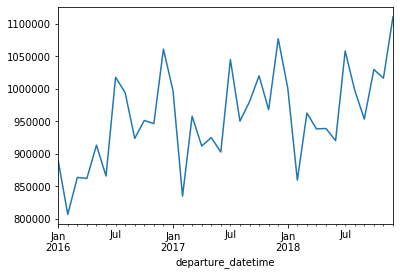

In [28]:
df_sp_grouped_month.n_passengers.plot();

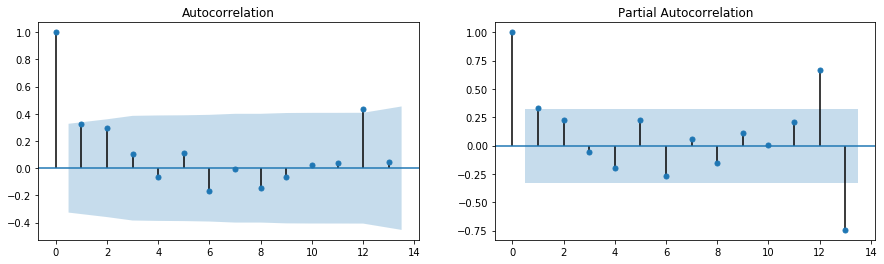

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = plot_acf(df_sp_grouped_month.seats_pass_diff, lags=13, ax=axes[0])
fig = plot_pacf(df_sp_grouped_month.seats_pass_diff, lags=13, ax=axes[1])

In [25]:
#result = seasonal_decompose(df_sp_grouped_month['n_passengers'], model='additive', period=12)
#result.plot()
#plt.show();

In [24]:
#from statsmodels.tsa.seasonal import STL
#res = STL(df_sp_grouped_month['n_passengers']).fit()
#res.plot()
#plt.show()

## daily analysis

In [31]:
df_sp_grouped_day = df_sp.resample('D', on ='departure_datetime').sum()[['n_seats_offered','n_passengers']]

df_sp_grouped_day['seats_pass_diff'] =  df_sp_grouped_day.n_seats_offered -df_sp_grouped_day.n_passengers

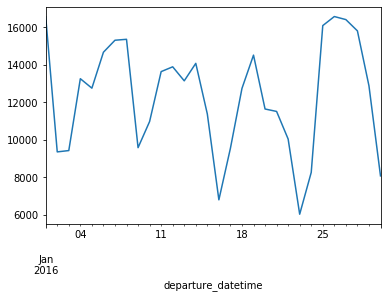

In [32]:
df_sp_grouped_day.seats_pass_diff.head(30).plot()

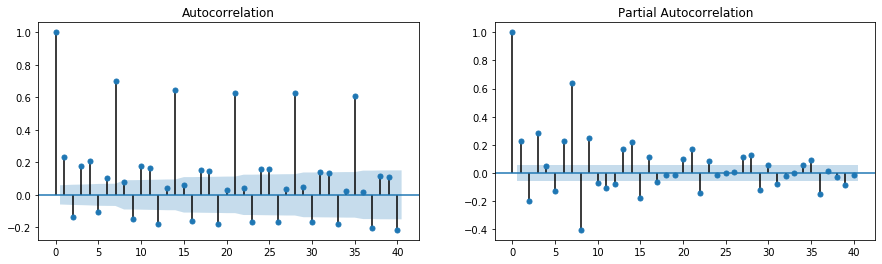

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = plot_acf(df_sp_grouped_day.n_passengers, lags=40, ax=axes[0])
fig = plot_pacf(df_sp_grouped_day.n_passengers, lags=40, ax=axes[1])

## Hourly analisys

In [34]:
# Resample into hourly bins

df_sp_grouped_hour = df_sp.resample('H', on ='departure_datetime').sum()[['n_seats_offered','n_passengers']]

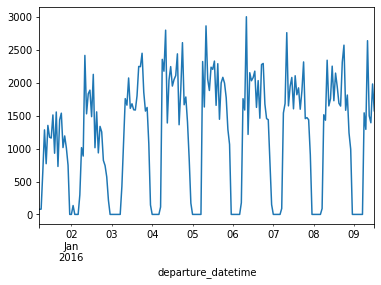

In [35]:
(df_sp_grouped_hour['n_passengers']).head(200).plot()

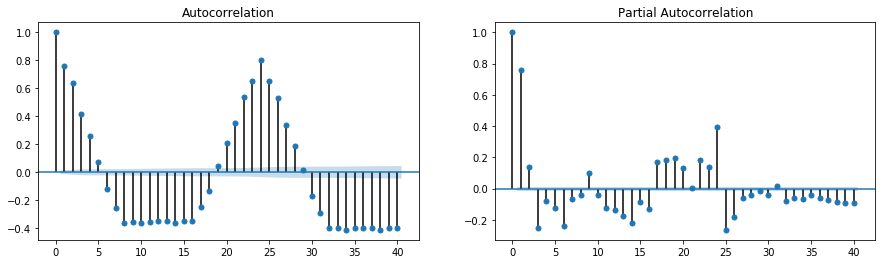

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = plot_acf(df_sp_grouped_hour.n_passengers, lags=40, ax=axes[0])
fig = plot_pacf(df_sp_grouped_hour.n_passengers, lags=40, ax=axes[1])

## General

In [43]:
df_sp.describe().T

,count,mean,std,min,25%,50%,75%,max
departure_day_of_month,288035.0,15.718010,8.787708,1.0,8.0,16.0,23.0,31.0
departure_month_encoded,288035.0,6.523985,3.454433,1.0,4.0,7.0,10.0,12.0
fl_holiday,288035.0,0.036089,0.186513,0.0,0.0,0.0,0.0,1.0
fl_holiday_d1,288035.0,0.036395,0.187271,0.0,0.0,0.0,0.0,1.0
fl_holiday_d2,288035.0,0.036530,0.187606,0.0,0.0,0.0,0.0,1.0
fl_holiday_d3,288035.0,0.037676,0.190412,0.0,0.0,0.0,0.0,1.0
year,288035.0,2017.001028,0.817187,2016.0,2016.0,2017.0,2018.0,2018.0
n_seats_offered,288035.0,158.609096,21.695685,0.0,138.0,174.0,177.0,379.0
n_passengers,288035.0,119.598031,33.094808,0.0,98.0,123.0,143.0,313.0


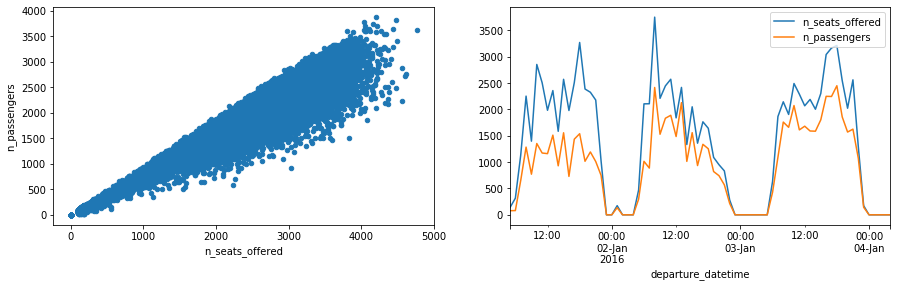

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

df_sp_grouped_hour.plot.scatter(x = 'n_seats_offered',y='n_passengers',ax=axes[])
df_sp_grouped_hour.head(72).plot(ax=axes[1])

# Naive predictor

In [157]:
df_train.head()

,n_seats_offered,n_passengers,year,month_day_hour
departure_datetime,,,,
2016-01-01 05:00:00,138.0,78.0,2016,01-01 05
2016-01-01 06:00:00,315.0,80.0,2016,01-01 06
2016-01-01 07:00:00,1132.0,651.0,2016,01-01 07
2016-01-01 08:00:00,2253.0,1285.0,2016,01-01 08
2016-01-01 09:00:00,1398.0,771.0,2016,01-01 09


In [74]:
class naive_predictor():
    def __init__(self,year0:str,year1:str):
        self.baseYear = year0
        self.incrementYear = year1
    
    def fit(self,df_train:pd.DataFrame ,target:str):
        df_train['year'] = df_train.index.year
        df_train['month_day_hour'] = df_train.index.strftime("%m-%d %H")
        dfs = [df_train.query(f"year == {int(i)}") for i in [self.baseYear,self.incrementYear]]
        df_joined = reduce(lambda left,right: pd.merge(left,right,on='month_day_hour'), dfs)
        
        self.slope = 1+((df_joined[target+'_x'].sum() - df_joined[target+'_y'].sum())/df_joined[target+'_y'].sum())
        self.predictions = df_train.
        
    def predict():
        

,n_seats_offered,n_passengers,year,month_day_hour
departure_datetime,,,,
2016-01-01 05:00:00,138.0,78.0,2016,01-01 05
2016-01-01 06:00:00,315.0,80.0,2016,01-01 06
2016-01-01 07:00:00,1132.0,651.0,2016,01-01 07
2016-01-01 08:00:00,2253.0,1285.0,2016,01-01 08
2016-01-01 09:00:00,1398.0,771.0,2016,01-01 09


In [159]:
dfs = [df_train.query(f"year == {i}") for i in [2017,2018]]

df_final = reduce(lambda left,right: pd.merge(left,right,on='month_day_hour'), dfs)

In [115]:
((df_final.n_passengers.sum() - df_final.n_passengers_y.sum())/df_final.n_passengers_y.sum())

0.018743242388167252

In [116]:
n_pred = df_final.n_passengers * (1+(df_final.n_passengers.sum() - df_final.n_passengers_y.sum())/df_final.n_passengers_y.sum())

In [131]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

df_final.['pred'].head().plot(ax=axes[0]);
df_oot.n_passengers.head(48).plot(ax=axes[1])

SyntaxError: invalid syntax (<ipython-input-131-77d147a3f22f>, line 3)

In [129]:
mean_absolute_error(df_final.pred,df_oot.n_passengers)

ValueError: Found input variables with inconsistent numbers of samples: [8755, 8753]

# SARIMAX

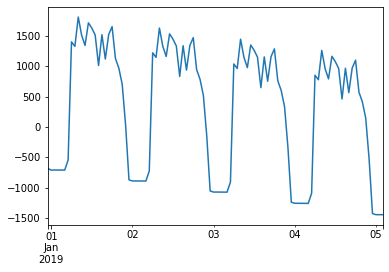

In [65]:
mod_sarimax = sm.tsa.SARIMAX(df_sp_grouped_hour['n_passengers'], order=(1,1,1),
                             seasonal_order=(0,1,1,24), trend = 't')
res_sarimax = mod_sarimax.fit()


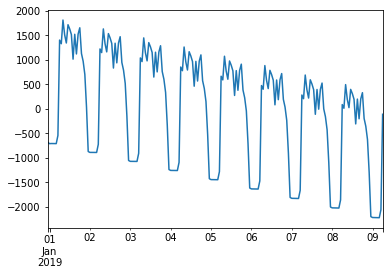

In [66]:
yhat = res_sarimax.forecast(200)

yhat.plot()

# FB Prophet

In [ ]:
df = df_sp_grouped_hour.reset_index()
df= df[['departure_datetime','n_passengers']]
df.columns = ['ds','y']
m = Prophet()
m.fit(df)


future = m.make_future_dataframe(periods=100)


forecast = m.predict(future)


fig1 = m.plot(forecast)

# Modeling One Hot Encoding

In [102]:
# Encoding days of the week and month variables
#df_sp_grouped.drop(['departure_date'],axis=1,inplace = True)


df_sp_hour = df_sp.resample('H', on ='departure_datetime').agg({#'n_seats_offered':'sum',
                                                                'n_passengers':'sum',
                                                                'departure_day_of_month':'max',
                                                                'departure_day_of_week':'max',
                                                                'departure_month':'max',
                                                                'departure_month_encoded':'max',
                                                                'fl_holiday':'max',
                                                                'fl_holiday_d1':'max',
                                                                'fl_holiday_d2':'max',
                                                                'fl_holiday_d3':'max',
                                                                'year':'max'})

cat_vars = [ 'departure_day_of_week', 'departure_month']
df_sp_H = cat_encoding(df_sp_hour,cat_vars, encoding = 'one_hot')

df_2020 = df_sp_H.query('year == 2020')
df_oot = df_sp_H.query('year == 2019')
df = df_sp_H.query('year < 2019')


# Resample into hourly bins

#cat_vars = df_sp_grouped.select_dtypes(include='object').columns.values.tolist()

In [80]:
df_sp_hour.head(24)

,n_passengers,departure_day_of_month,departure_day_of_week,departure_month,departure_month_encoded,fl_holiday,fl_holiday_d1,fl_holiday_d2,fl_holiday_d3,year
departure_datetime,,,,,,,,,,
2016-01-01 05:00:00,78,1.0,fri,jan,1.0,1.0,0.0,0.0,0.0,2016.0
2016-01-01 06:00:00,80,1.0,fri,jan,1.0,1.0,0.0,0.0,0.0,2016.0
2016-01-01 07:00:00,651,1.0,fri,jan,1.0,1.0,0.0,0.0,0.0,2016.0
2016-01-01 08:00:00,1285,1.0,fri,jan,1.0,1.0,0.0,0.0,0.0,2016.0
2016-01-01 09:00:00,771,1.0,fri,jan,1.0,1.0,0.0,0.0,0.0,2016.0
2016-01-01 10:00:00,1353,1.0,fri,jan,1.0,1.0,0.0,0.0,0.0,2016.0
2016-01-01 11:00:00,1173,1.0,fri,jan,1.0,1.0,0.0,0.0,0.0,2016.0
2016-01-01 12:00:00,1161,1.0,fri,jan,1.0,1.0,0.0,0.0,0.0,2016.0
2016-01-01 13:00:00,1512,1.0,fri,jan,1.0,1.0,0.0,0.0,0.0,2016.0


In [103]:
# X,y 

X_train = df.drop(columns=['n_passengers'])
y_train = df.n_passengers

X_test = df_oot.drop(columns=['n_passengers'])
y_test = df_oot.n_passengers

In [45]:
X_train.head()

,departure_day_of_month,departure_month_encoded,fl_holiday,fl_holiday_d1,fl_holiday_d2,fl_holiday_d3,year,departure_day_of_week_fri,departure_day_of_week_mon,departure_day_of_week_sat,departure_day_of_week_sun,departure_day_of_week_thu,departure_day_of_week_tue,departure_day_of_week_wed,departure_month_apr,departure_month_aug,departure_month_dec,departure_month_feb,departure_month_jan,departure_month_jul,departure_month_jun,departure_month_mar,departure_month_may,departure_month_nov,departure_month_oct,departure_month_sep
departure_datetime,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 05:00:00,1.0,1.0,1.0,0.0,0.0,0.0,2016.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2016-01-01 06:00:00,1.0,1.0,1.0,0.0,0.0,0.0,2016.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2016-01-01 07:00:00,1.0,1.0,1.0,0.0,0.0,0.0,2016.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2016-01-01 08:00:00,1.0,1.0,1.0,0.0,0.0,0.0,2016.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2016-01-01 09:00:00,1.0,1.0,1.0,0.0,0.0,0.0,2016.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


## Random Forests

### Random Search

In [113]:
if training:

    rf = RandomForestRegressor(random_state=seed, n_jobs=-1)
    #random_grid = {'bootstrap': [True, False],
    #               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    #               'max_features': ['auto', 'sqrt'],
    #               'min_samples_leaf': [1, 2, 4],
    #               'min_samples_split': [2, 5, 10],
    #               'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
    
    random_grid = {'bootstrap': [True, False],
               'max_depth': [4, 5, 6, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [200, 400, 600]}
    
    # Time series CV

    tscv = TimeSeriesSplit(n_splits = 5)

    BayesCV = BayesSearchCV(rf,random_grid, n_iter = 50, cv = tscv, verbose=2, random_state=seed, n_jobs = -1)
    
    # Fit the random search model
    BayesCV.fit(X_train, y_train)
    
    print(BayesCV.best_params_)
    
    rand_reg = BayesCV.best_estimator_.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).



Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.1s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).



Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.9s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).



Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).



Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.3s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).



Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.1s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.0s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.7s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.2s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.3s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.4s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.1s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.3s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.1s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.1s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.2s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.2s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.1s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.3s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.0s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.2s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.2s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.3s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.1s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.4s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.2s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.0s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.0s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.1s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/home/welberth/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for exa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished
/home/welberth/.local/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:294: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).



OrderedDict([('bootstrap', True), ('max_depth', 70), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 10), ('n_estimators', 400)])


In [72]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,rand_reg.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,rand_reg.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, rand_reg.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, rand_reg.predict(X_test))**0.5))


train MAE: 526.52
test MAE: 581.72
train RMSE: 684.99
test RMSE: 746.38


In [114]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,rand_reg.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,rand_reg.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, rand_reg.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, rand_reg.predict(X_test))**0.5))

train MAE: 518.93
test MAE: 582.78
train RMSE: 677.35
test RMSE: 748.87


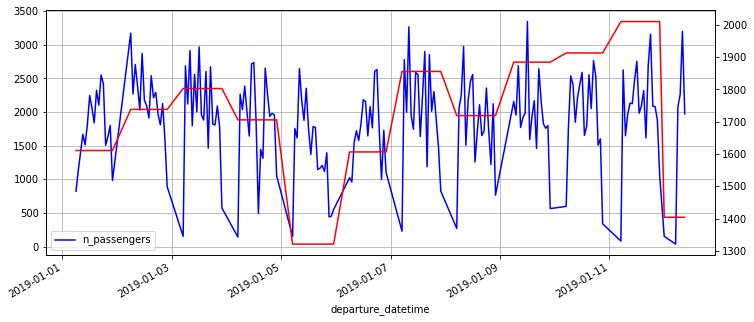

In [115]:
plt.figure(figsize=(12,5))

df_out = y_test.copy().to_frame()
# Number of request every 10 minutes
y_test.iloc[0:200].plot(color='blue', grid=True)
plt.legend(loc='upper left')
plt.xlabel('Number of request ever 10 minute')

df_out['oth'] = rand_reg.predict(X_test)
# Sum of response size over each 10 minute
#y_test.plot(color='blue', grid=True)
#plt.legend(loc='upper left')
#plt.xlabel('Number of request ever 10 minute')
df_out.oth.iloc[0:200].plot(color='red',grid=True, secondary_y=True)
#plt.legend(loc='upper right')pd.Series(rand_reg.predict(X_test)).iloc[0:100]
#plt.show()

### Grid Search

In [108]:
if training:

    rf = RandomForestRegressor(random_state=seed, n_jobs=-1)

    param_grid = {'n_estimators': [2000],
                  'min_samples_split': [2],
                  'min_samples_leaf': [1],
                  'max_features': ['sqrt'],
                  'max_depth': [5,10,15],
                  'bootstrap': [True]}

    grid = GridSearchCV(rf, param_grid=param_grid, cv=5,return_train_score = True,scoring = 'neg_mean_absolute_error').fit(X_train, y_train)
    
    #neg_root_mean_squared_error
    reg_rf = grid.best_estimator_.fit(X_train,y_train)

    print(grid.best_params_)
   # print(grid.cv_results_)

{'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2000}


In [109]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,reg_rf.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,reg_rf.predict(X_test))))
print("train MAPE: {:.2f}%".format(MAPE(y_train, reg_rf.predict(X_train))))
print("test MAPE: {:.2f}%".format(MAPE(y_test, reg_rf.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, reg_rf.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, reg_rf.predict(X_test))**0.5))
print("---------------")
print("Out of Time MAE: {:.2f}".format(mean_absolute_error(y_oot,reg_rf.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time MAPE: {:.2f}%".format(MAPE(y_oot, reg_rf.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time RMSE: {:.2f}".format(mean_squared_error(y_oot, reg_rf.predict(X_oot.drop(columns = ['departure_date'])))**0.5))

train MAE: 29.16
test MAE: 38.05
train MAPE: 15.32%
test MAPE: 20.74%
train RMSE: 40.30
test RMSE: 53.31
---------------
Out of Time MAE: 46.20
Out of Time MAPE: 39.74%
Out of Time RMSE: 65.27


In [49]:
rf = RandomForestRegressor(n_estimators = 300,
                               min_samples_split =2,
                               min_samples_leaf =1,
                               max_features = 'sqrt',
                               max_depth = 15,
                               bootstrap = True,
                               random_state=seed,
                               n_jobs=-1)
    #neg_root_mean_squared_error
reg_rf = rf.fit(X_train,y_train)


[<matplotlib.lines.Line2D at 0x7fd48b180128>]

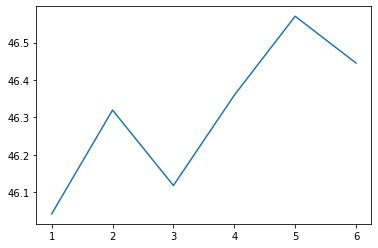

In [48]:
plt.plot(list(range(1,7,1)),MAE)

In [35]:
list(range(100,500,10))

[100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200,
 210,
 220,
 230,
 240,
 250,
 260,
 270,
 280,
 290,
 300,
 310,
 320,
 330,
 340,
 350,
 360,
 370,
 380,
 390,
 400,
 410,
 420,
 430,
 440,
 450,
 460,
 470,
 480,
 490]

In [50]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,reg_rf.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,reg_rf.predict(X_test))))
print("train MAPE: {:.2f}%".format(MAPE(y_train, reg_rf.predict(X_train))))
print("test MAPE: {:.2f}%".format(MAPE(y_test, reg_rf.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, reg_rf.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, reg_rf.predict(X_test))**0.5))
print("---------------")
print("Out of Time MAE: {:.2f}".format(mean_absolute_error(y_oot,reg_rf.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time MAPE: {:.2f}%".format(MAPE(y_oot, reg_rf.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time RMSE: {:.2f}".format(mean_squared_error(y_oot, reg_rf.predict(X_oot.drop(columns = ['departure_date'])))**0.5))

train MAE: 29.17
test MAE: 38.04
train MAPE: 15.29%
test MAPE: 20.71%
train RMSE: 40.33
test RMSE: 53.35
---------------
Out of Time MAE: 46.04
Out of Time MAPE: 39.18%
Out of Time RMSE: 65.09


## lightGBM

### Random Search

In [32]:
lg = lgb.LGBMRegressor(random_state=seed,n_jobs=-1)


lgbmrandom_grid = {
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
               'learning_rate': [0.01,0.05,0.1],
               'colsample_bytree' : [0.3,0.5,1],
               'num_leaves' : [20,30,40,50,60],
               'subsample' : [0.2,0.3,0.5,1] ,
               'reg_alpha' : [0,0.5,1,2],
               'min_child_samples': [1, 2, 4],
               'n_estimators': [1000, 1600, 1800, 2000, 2500, 3000,3500,4000,4500,5000]}


lgbmrandom_grid = RandomizedSearchCV(estimator = lg,
                                     param_distributions = lgbmrandom_grid,
                                     n_iter = 300,
                                     cv = 3,
                                     random_state=seed,
                                     scoring = "neg_mean_absolute_error")

# Fit the random search model
lgbmrandom_grid.fit(X_train, y_train)

print(lgbmrandom_grid.best_params_)

lgbmrand_reg = lgbmrandom_grid.best_estimator_.fit(X_train, y_train)

{'subsample': 1, 'reg_alpha': 0, 'num_leaves': 30, 'n_estimators': 4500, 'min_child_samples': 2, 'max_depth': 50, 'learning_rate': 0.05, 'colsample_bytree': 0.5}


In [33]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,lgbmrand_reg.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,lgbmrand_reg.predict(X_test))))
print("train MAPE: {:.2f}%".format(MAPE(y_train, lgbmrand_reg.predict(X_train))))
print("test MAPE: {:.2f}%".format(MAPE(y_test, lgbmrand_reg.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, lgbmrand_reg.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, lgbmrand_reg.predict(X_test))**0.5))
print("---------------")
print("Out of Time MAE: {:.2f}".format(mean_absolute_error(y_oot,lgbmrand_reg.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time MAPE: {:.2f}%".format(MAPE(y_oot,lgbmrand_reg.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time RMSE: {:.2f}".format(mean_squared_error(y_oot, lgbmrand_reg.predict(X_oot.drop(columns = ['departure_date'])))**0.5))

train MAE: 14.37
test MAE: 30.95
train MAPE: 8.38%
test MAPE: 16.30%
train RMSE: 18.99
test RMSE: 44.29
---------------
Out of Time MAE: 46.50
Out of Time MAPE: 33.42%
Out of Time RMSE: 66.98


### Grid Search

In [34]:
lg = lgb.LGBMRegressor(random_state=seed,n_jobs=-1)

if training:

    param_grid = {
               'max_depth': [30],
               'learning_rate': [0.05],
               'colsample_bytree' : [0.5],
               'num_leaves' : [50],
               'subsample' : [0.25] ,
               'reg_alpha' : [1.2],
               'min_child_samples': [1],
               'n_estimators': [4500]}

    grid = GridSearchCV(lg, param_grid=param_grid, cv=5,return_train_score = True,scoring = 'neg_mean_absolute_error').fit(X_train, y_train)
    
    #neg_root_mean_squared_error
    reg_lgb = grid.best_estimator_.fit(X_train,y_train)

    print(grid.best_params_)
   # print(grid.cv_results_)

#{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 30, 'min_child_samples': 1, 'n_estimators': 4500, 'num_leaves': 50, 'reg_alpha': 0, 'subsample': 0.25}

{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 30, 'min_child_samples': 1, 'n_estimators': 4500, 'num_leaves': 50, 'reg_alpha': 1.2, 'subsample': 0.25}


In [35]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,reg_lgb.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,reg_lgb.predict(X_test))))
print("train MAPE: {:.2f}%".format(MAPE(y_train, reg_lgb.predict(X_train))))
print("test MAPE: {:.2f}%".format(MAPE(y_test, reg_lgb.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, reg_lgb.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, reg_lgb.predict(X_test))**0.5))
print("---------------")
print("Out of Time MAE: {:.2f}".format(mean_absolute_error(y_oot,reg_lgb.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time MAPE: {:.2f}%".format(MAPE(y_oot, reg_lgb.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time RMSE: {:.2f}".format(mean_squared_error(y_oot, reg_lgb.predict(X_oot.drop(columns = ['departure_date'])))**0.5))

train MAE: 9.91
test MAE: 30.94
train MAPE: 5.86%
test MAPE: 16.24%
train RMSE: 12.94
test RMSE: 44.33
---------------
Out of Time MAE: 47.14
Out of Time MAPE: 33.72%
Out of Time RMSE: 67.74


# Modeling Label Encoding

In [59]:
# Encoding days of the week and month variables
#df_sp_grouped.drop(['departure_date'],axis=1,inplace = True)

#cat_vars = df_sp_grouped.select_dtypes(include='object').columns.values.tolist()
cat_vars = [ 'departure_day_of_week', 'departure_month', 'arrival_day_of_week']
df_sp_grouped = cat_encoding(df_sp_grouped,cat_vars, encoding = 'label')

In [63]:
# Out of time set
X_oot = df_sp_grouped.query("departure_date.str.contains('2020-02')", engine='python').drop(['n_passengers'],axis=1)
y_oot = df_sp_grouped.query("departure_date.str.contains('2020-02')", engine='python').n_passengers

# Trains test split
X = df_sp_grouped[~df_sp_grouped["departure_date"].str.contains('2020-02')].drop(columns = ['n_passengers','departure_date'])
y = df_sp_grouped[~df_sp_grouped["departure_date"].str.contains('2020-02')].n_passengers


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

In [61]:
lg = lgb.LGBMRegressor(random_state=seed,n_jobs=-1)


lgbmrandom_grid = {
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
               'learning_rate': [0.01,0.05,0.1],
               'colsample_bytree' : [0.3,0.5,1],
               'num_leaves' : [20,30,40,50,60],
               'subsample' : [0.2,0.3,0.5,1] ,
               'reg_alpha' : [0,0.5,1,2],
               'min_child_samples': [1, 2, 4],
               'n_estimators': [1000, 1600, 1800, 2000, 2500, 3000,3500,4000,4500,5000]}


lgbmrandom_grid = RandomizedSearchCV(estimator = lg,
                                     param_distributions = lgbmrandom_grid,
                                     n_iter = 300,
                                     cv = 3,
                                     random_state=seed,
                                     scoring = "neg_mean_absolute_error")

# Fit the random search model
lgbmrandom_grid.fit(X_train, y_train)

print(lgbmrandom_grid.best_params_)

lgbmrand_reg = lgbmrandom_grid.best_estimator_.fit(X_train, y_train)

{'subsample': 0.2, 'reg_alpha': 0, 'num_leaves': 40, 'n_estimators': 2500, 'min_child_samples': 4, 'max_depth': 80, 'learning_rate': 0.05, 'colsample_bytree': 0.5}


In [64]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,lgbmrand_reg.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,lgbmrand_reg.predict(X_test))))
print("train MAPE: {:.2f}%".format(MAPE(y_train, lgbmrand_reg.predict(X_train))))
print("test MAPE: {:.2f}%".format(MAPE(y_test, lgbmrand_reg.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, lgbmrand_reg.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, lgbmrand_reg.predict(X_test))**0.5))
print("---------------")
print("Out of Time MAE: {:.2f}".format(mean_absolute_error(y_oot,lgbmrand_reg.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time MAPE: {:.2f}%".format(MAPE(y_oot,lgbmrand_reg.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time RMSE: {:.2f}".format(mean_squared_error(y_oot, lgbmrand_reg.predict(X_oot.drop(columns = ['departure_date'])))**0.5))

train MAE: 18.23
test MAE: 32.40
train MAPE: 10.37%
test MAPE: 17.06%
train RMSE: 24.41
test RMSE: 46.12
---------------
Out of Time MAE: 45.87
Out of Time MAPE: 33.12%
Out of Time RMSE: 67.15


# Importance of Variables

In [ ]:
explainer = shap.TreeExplainer(lgbmrand_reg, approximate = True)

In [ ]:

rf_shap_values = explainer.shap_values(X_test.iloc[0:1000,:])


#import matplotlib.pyplot as plt
#f = plt.figure()
#shap.summary_plot(rf_shap_values, X_test)

In [ ]:
shap.summary_plot(rf_shap_values, X_test.iloc[0:1000,:])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, rf_shap_values[10,:], X_test.iloc[10,:])

In [22]:
pd.concat([y_oot.reset_index(drop=True),pd.Series(lgbmrand_reg.predict(X_oot.drop(columns = ['departure_date'])))],axis=1)[100:120].plot()

NameError: name 'y_oot' is not defined

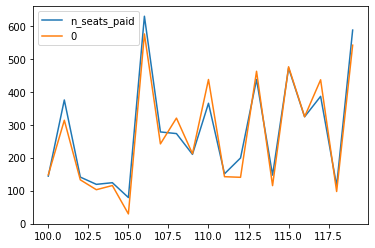

In [66]:
pd.concat([y_test.reset_index(drop=True),pd.Series(lgbmrand_reg.predict(X_test))],axis=1)[100:120].plot()

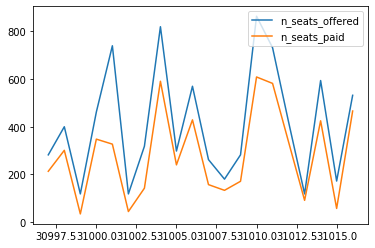

In [21]:
df_sp_grouped.query("departure_date.str.contains('2020-02')", engine='python')[['n_seats_offered','n_passengers']][100:120].plot()

Optimal number of features : 11


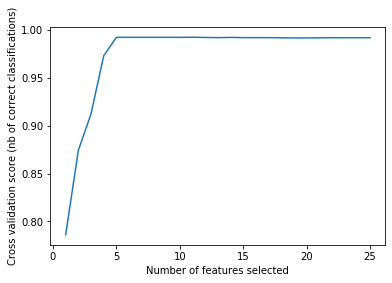

In [51]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000, n_features=25, n_informative=5,
                           n_redundant=0, n_repeated=5, n_classes=2,
                           n_clusters_per_class=1, random_state=0)

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=5,
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()